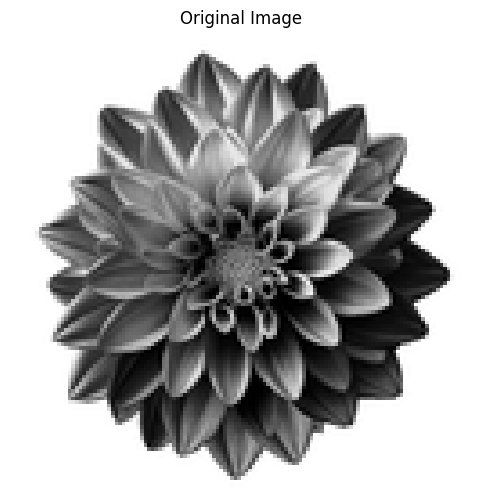

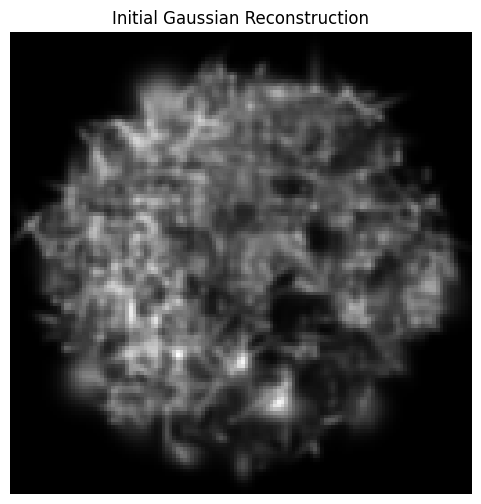

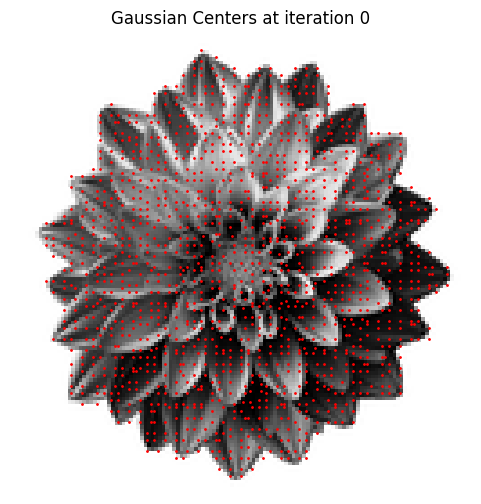

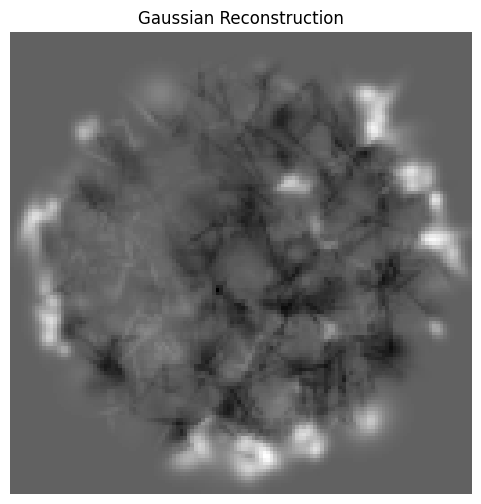

Iteration 0/250, Loss: 0.7520678639411926, LR: 0.5
Iteration 10/250, Loss: 0.15711569786071777, LR: 0.5
Iteration 20/250, Loss: 0.03478558361530304, LR: 0.5
Iteration 30/250, Loss: 0.015151686035096645, LR: 0.5
Iteration 40/250, Loss: 0.011211779899895191, LR: 0.5


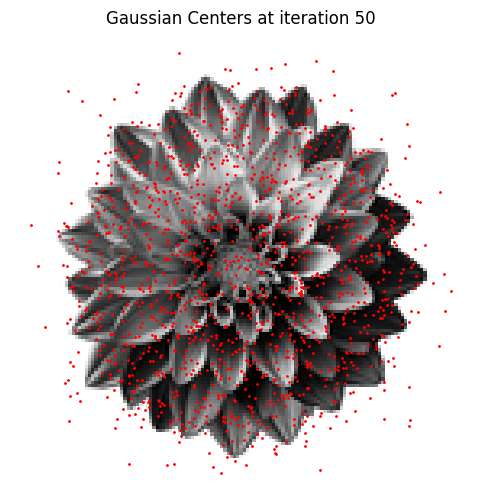

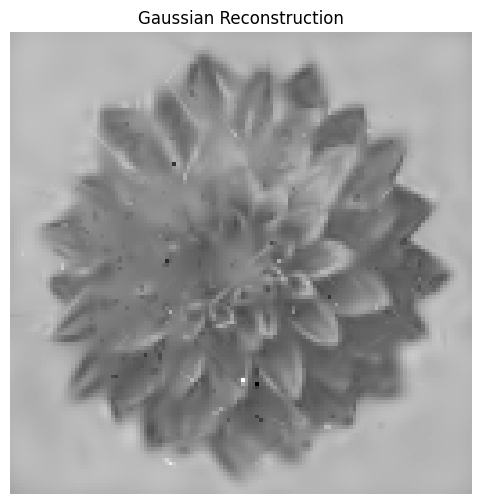

Iteration 50/250, Loss: 0.006764130666851997, LR: 0.5
Iteration 60/250, Loss: 0.004452114924788475, LR: 0.5
Iteration 70/250, Loss: 0.005141044035553932, LR: 0.5
Iteration 80/250, Loss: 0.0033466701861470938, LR: 0.5
Iteration 90/250, Loss: 0.0022904120851308107, LR: 0.5


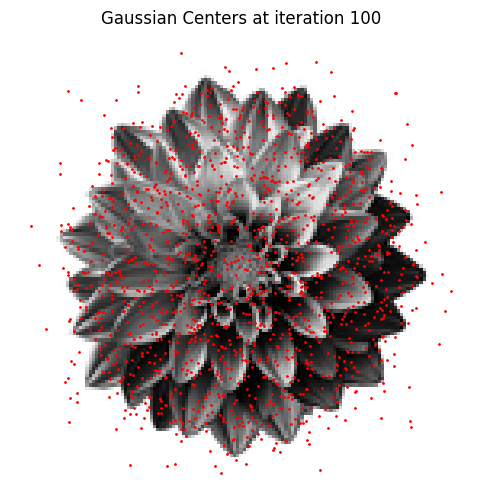

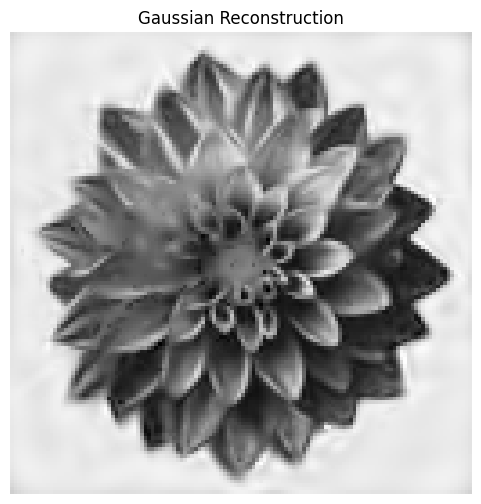

Iteration 100/250, Loss: 0.001911840750835836, LR: 0.35
Iteration 110/250, Loss: 0.0015971240354701877, LR: 0.35
Iteration 120/250, Loss: 0.001443573273718357, LR: 0.35
Iteration 130/250, Loss: 0.0013229460455477238, LR: 0.35
Iteration 140/250, Loss: 0.0012294063344597816, LR: 0.35


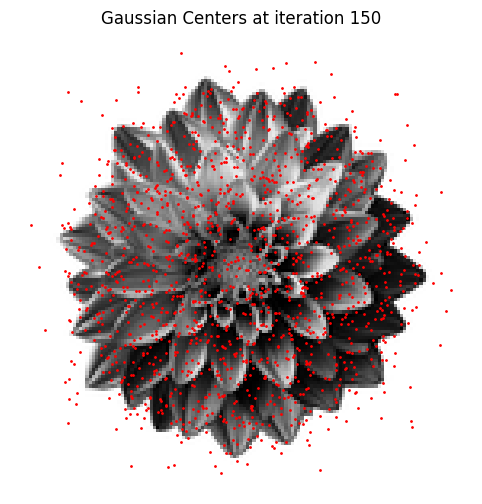

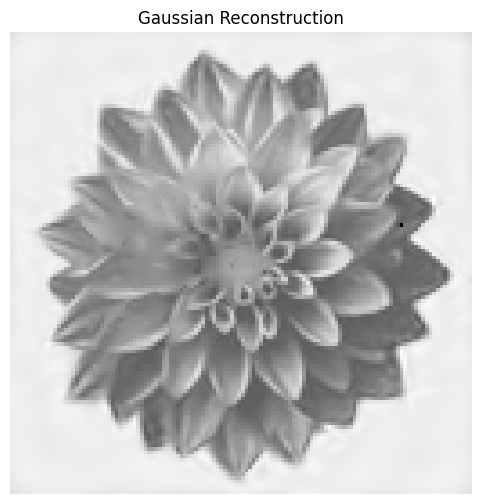

Iteration 150/250, Loss: 0.001154700992628932, LR: 0.35
Iteration 160/250, Loss: 0.001092561287805438, LR: 0.35
Iteration 170/250, Loss: 0.001049908110871911, LR: 0.35
Iteration 180/250, Loss: 0.0011192683596163988, LR: 0.35
Iteration 190/250, Loss: 0.0020006615668535233, LR: 0.35


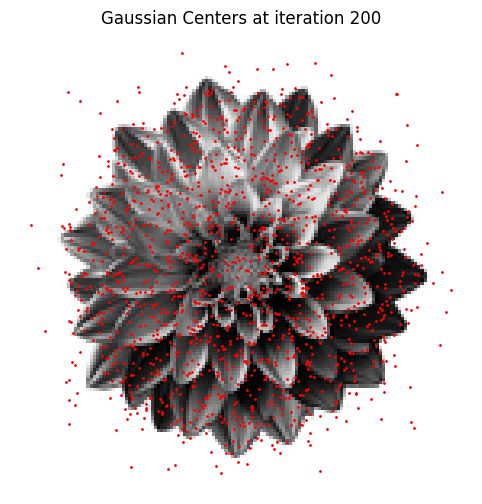

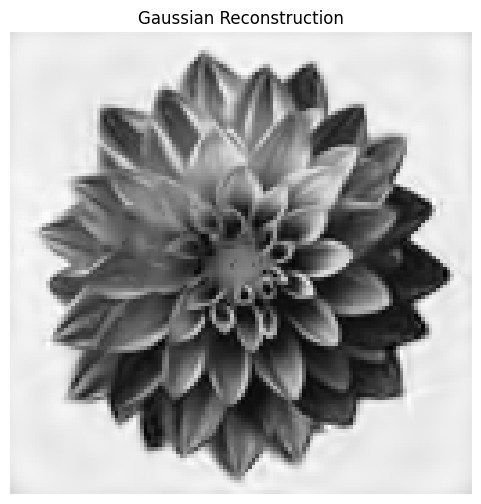

Iteration 200/250, Loss: 0.0014911233447492123, LR: 0.24499999999999997
Iteration 210/250, Loss: 0.0010360428132116795, LR: 0.24499999999999997
Iteration 220/250, Loss: 0.0008799599017947912, LR: 0.24499999999999997
Iteration 230/250, Loss: 0.0008487554150633514, LR: 0.24499999999999997
Iteration 240/250, Loss: 0.0008138156263157725, LR: 0.24499999999999997


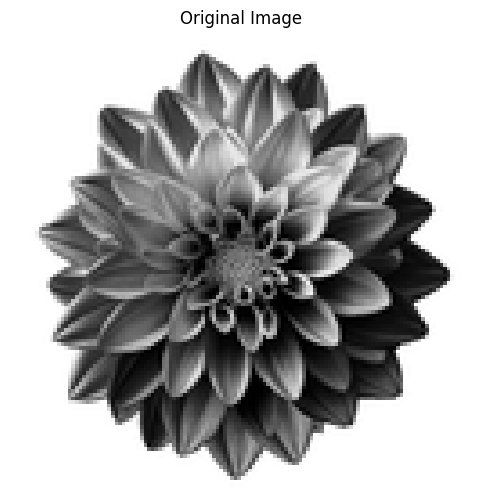

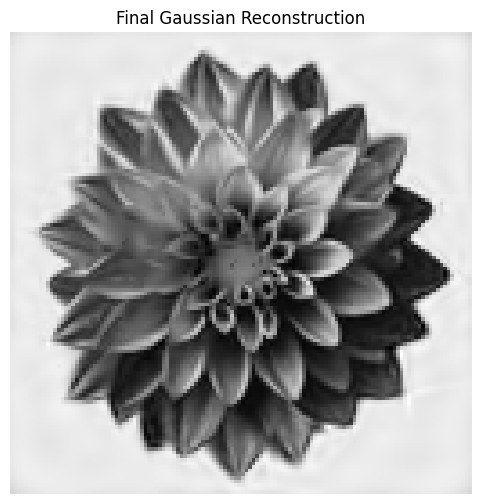

In [41]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from IPython.display import Video, display

# Load and normalize the image
image_path = '/home/justin/Pictures/purple-flower.png'
image = Image.open(image_path).convert('L')

desired_size = (128, 128)  # Desired resolution
image = image.resize(desired_size, Image.LANCZOS)

img_np = np.array(image) / 255.0
img_tensor = torch.tensor(img_np).float().cuda()

def plot_image(img_array, title, params=None, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.imshow(img_array, cmap=cmap)
    if params is not None:
        plt.scatter(params[::7], params[1::7], color='red', s=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the original image
plot_image(img_np, "Original Image")

# Define the 2D Gaussian function with a color intensity parameter and rotation angle
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle):
    # Calculate the centered coordinates
    x_centered = x - mu_x
    y_centered = y - mu_y
    
    # Rotate the coordinates
    x_rot = x_centered * torch.cos(rotation_angle) - y_centered * torch.sin(rotation_angle)
    y_rot = x_centered * torch.sin(rotation_angle) + y_centered * torch.cos(rotation_angle)
    
    exponent = -((x_rot**2) / (2*sigma_x**2) + (y_rot**2) / (2*sigma_y**2))
    # print(color_intensity)
    return (torch.exp(exponent)) * color_intensity

# Model the image using a set of rotated Gaussians
def model_image(params, shape):
    x = torch.linspace(0, shape[1] - 1, shape[1]).cuda()
    y = torch.linspace(0, shape[0] - 1, shape[0]).cuda()
    x, y = torch.meshgrid(x, y)
    model = torch.zeros_like(x)
    for i in range(0, len(params), 7): 
        mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle, _ = params[i:i+7]
        model += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle)
    
    return model

# Mean squared error loss function
def mse_loss(params):
    model = model_image(params, img_tensor.shape)
    loss = torch.mean((model - img_tensor)**2)
    return loss

# Initialization using grid approach and sampling the image
num_gaussians = 2500
grid_size = int(np.sqrt(num_gaussians))
params = []
image_height, image_width = img_tensor.shape

for i in range(grid_size):
    for j in range(grid_size):
        # Calculate the coordinates within the image
        x_coord = (i * image_width) // grid_size
        y_coord = (j * image_height) // grid_size
        if img_tensor[y_coord, x_coord] > .9:
            continue
        
        # Sample the color intensity from the image at the calculated coordinates
        color_intensity = img_tensor[y_coord, x_coord]
        
        mu_x = torch.tensor(x_coord).float().cuda()
        mu_y = torch.tensor(y_coord).float().cuda()
        sigma_x = torch.randn(1).mul(2).add(1).clamp(1, 20).cuda()
        sigma_y = torch.randn(1).mul(2).add(1).clamp(1, 20).cuda()
        rotation_angle = torch.rand(1).mul(2 * np.pi).cuda()  # Random rotation angle
        
        params.extend([mu_x.item(), mu_y.item(), sigma_x.item(), sigma_y.item(), color_intensity.item(), rotation_angle.item(), 0.0])

params = torch.tensor(params, device='cuda').requires_grad_()
optimizer = optim.Adam([params], lr=0.5) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# Display the initial Gaussian-based reconstruction
initial_model = model_image(params, img_tensor.shape).cpu().detach().numpy()
plot_image(initial_model, "Initial Gaussian Reconstruction")

# Optimize with scheduler step
iterations = 250
display_interval = 50  # Display the Gaussian centers every 100 iterations
all_frames = []
for iteration in range(iterations):
    optimizer.zero_grad()
    loss = mse_loss(params)
    loss.backward()
    optimizer.step()
    scheduler.step()
    model = model_image(params, img_tensor.shape)
    all_frames.append((torch.sigmoid(model).cpu().detach().numpy() * 255).astype(np.uint8))
    if iteration % display_interval == 0:
        plot_image(img_np, f"Gaussian Centers at iteration {iteration}", params=params.cpu().detach().numpy())
        model = model_image(params, img_tensor.shape)
        plot_image(model.cpu().detach().numpy(), "Gaussian Reconstruction")
    if iteration % 10 == 0:
        print(f"Iteration {iteration}/{iterations}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

# Display result
result = model_image(params, img_tensor.shape).cpu().detach().numpy()
plot_image(img_np, "Original Image")
plot_image(result, "Final Gaussian Reconstruction")
video_path = './data/gaussian_reconstruction.mp4'
imageio.mimwrite(video_path, all_frames, fps=12)
display(Video(video_path, width=800, height=800))